In [ ]:
%%capture --no-stderr
%pip install -U --quiet langchain-community langchain_openai tavily-python langgraph langchain_experimental

In [ ]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY:··········
TAVILY_API_KEY:··········


In [ ]:
from typing import Literal, Annotated
from langchain_openai import ChatOpenAI

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

from langchain_core.messages import HumanMessage

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

In [ ]:
tavily_tool = TavilySearchResults(max_results=2)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [ ]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["Researcher", "Coder"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

In [ ]:
from typing import Literal
from pydantic import BaseModel
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder

# Assuming options is a list of strings
class routeResponse(BaseModel):
    next: Literal[tuple(options)]  # Unpacks the options list

# Example of creating a prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=", ".join(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

In [ ]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("supervisor", supervisor_agent)

In [ ]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

# Set up memory
memory = MemorySaver()

graph = workflow.compile(checkpointer=memory,interrupt_before=["Coder"])

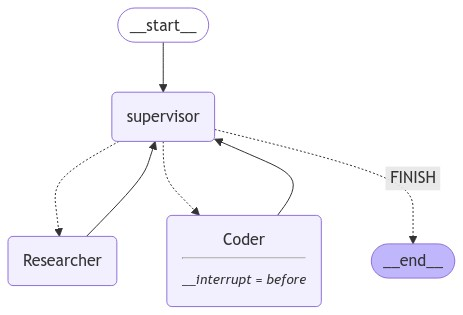

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
import pprint

input_prompt = """The goal is to generate a sales proposal for a weight loss drug that BioLama, a biotech startup, will pitch to Bausch Health, a Canadian pharmaceutical company. Additionally, you will guide the agents in calculating future ROI trends for the next 5 years, including generating a graph that visualizes the yearly ROI.

Task Overview:
Research and Proposal Generation

You can search online on different websites and gather relevant information about Bausch Health, the pharmaceutical industry, and market trends.
Generate a comprehensive sales proposal, which should include the following sections:
Executive Summary: Highlight the key points of the weight loss drug pitch and its importance for Bausch Health.
Company Overview (Bausch Health): Provide a detailed background on Bausch Health, its history, and its role in the pharmaceutical industry.
Product Description: Describe the new weight loss drug, its composition, mechanism of action, clinical benefits, and unique selling points.
Market Analysis: Research and analyze the current weight loss market, including competitor products, demand trends, and target demographics.
Marketing Strategy: Propose a marketing strategy, outlining the product’s positioning, target audience, and promotional channels.
Financial Projections: Estimate production costs (e.g., R&D, manufacturing, distribution) and project sales and revenue for the next 5 years.
Conclusion: Summarize the proposal and provide a compelling closing statement to convince Bausch Health to invest.

Once the proposal is generated, use the financial data (production costs, sales projections, revenue) for ROI calculation.

ROI Calculation and Graph Generation
Initial ROI Calculation:
The agent should calculate the ROI based on the financial data using the formula:
ROI = (Net Profit / Cost of Investment) * 100 where:

Net Profit: Total revenue minus total costs (including production, R&D, marketing).
Cost of Investment: Initial production and operational costs.
Yearly ROI Trends:
The agent will calculate the yearly ROI over 5 years and account for:

Market growth rate assumptions
Potential changes in production costs and economies of scale
Discounted cash flow (DCF) analysis for a more accurate future projection
Generate Graph:
The agent will create a graph showing the projected yearly ROI trend for the next 5 years, using Python plotting libraries (e.g., Matplotlib or Plotly). This graph should visualize how the ROI evolves year over year based on different assumptions (e.g., optimistic, moderate, and conservative scenarios).

Final Report
After the agent completes the ROI calculation and graph generation, review both the proposal and the ROI analysis. Consolidate the information into a final report that includes:

A summary of the sales proposal for the weight loss drug.
A visual representation of the 5-year ROI trends, showing the potential financial outcomes of the project.

Goal:
The final deliverable should be a comprehensive report that includes:

A well-researched, structured proposal to pitch the weight loss drug to Bausch Health.
A graph that clearly illustrates the projected ROI trends over the next 5 years, providing valuable insights for decision-makers at Bausch Health.
"""

# Run the graph
thread ={"configurable": {"thread_id": 42}}
final_state = graph.invoke(
    {"messages": [HumanMessage(content=input_prompt)]},
    config = thread
)

## Analyze the output of the workflow before going to the coder agent

In [ ]:
print(final_state["messages"][-1].content)

### Sales Proposal for BioLama's Weight Loss Drug Pitch to Bausch Health

---

#### Executive Summary
BioLama, a biotech startup, is pleased to present a groundbreaking weight loss drug to Bausch Health, a prominent Canadian pharmaceutical company. This proposal outlines the compelling reasons for Bausch Health to invest in our innovative product. The new drug promises significant clinical benefits, a novel mechanism of action, and a robust market potential, positioning it as a lucrative addition to Bausch Health's portfolio.

---

#### Company Overview: Bausch Health
Bausch Health Companies Inc. is a diversified global pharmaceutical company headquartered in Laval, Canada. Previously known as Valeant Pharmaceuticals International, Inc., the company rebranded in 2018 to Bausch Health. The company excels in developing, manufacturing, and marketing a range of products across various therapeutic areas including gastroenterology, hepatology, neurology, dermatology, and eye health. Bausch H

In [ ]:
state = graph.get_state({"configurable": {"thread_id": 42}})

In [ ]:
state.next

('Coder',)

## If the ouput looks good continue the execution to the coder agent

================================ Human Message =================================
Name: Researcher

### Sales Proposal for BioLama's Weight Loss Drug Pitch to Bausch Health

---

#### Executive Summary
BioLama, a biotech startup, is pleased to present a groundbreaking weight loss drug to Bausch Health, a prominent Canadian pharmaceutical company. This proposal outlines the compelling reasons for Bausch Health to invest in our innovative product. The new drug promises significant clinical benefits, a novel mechanism of action, and a robust market potential, positioning it as a lucrative addition to Bausch Health's portfolio.

---

#### Company Overview: Bausch Health
Bausch Health Companies Inc. is a diversified global pharmaceutical company headquartered in Laval, Canada. Previously known as Valeant Pharmaceuticals International, Inc., the company rebranded in 2018 to Bausch Health. The company excels in developing, manufacturing, and marketing a range of products across various therape

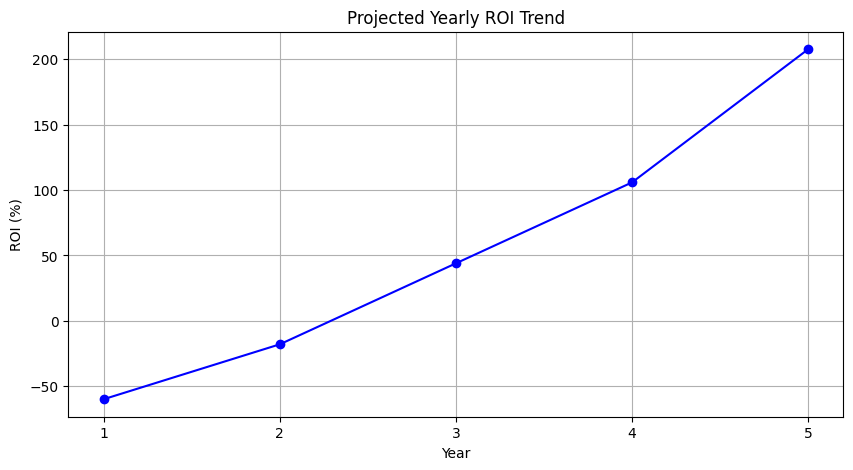

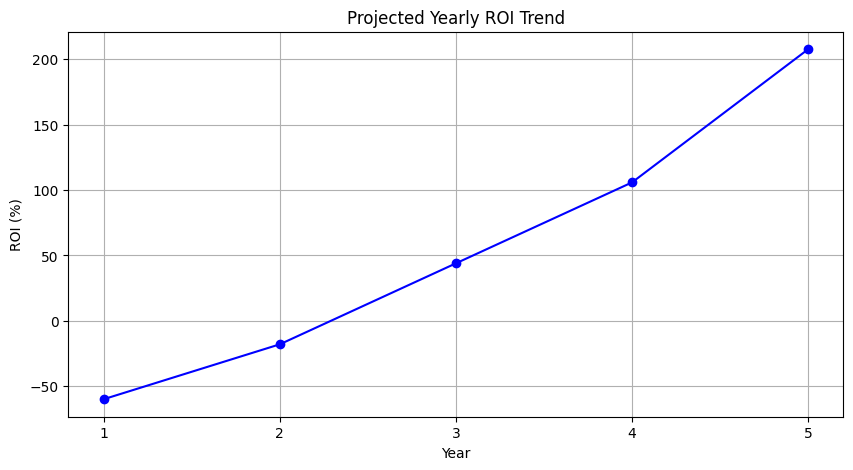

================================ Human Message =================================
Name: Coder

### Final Report: BioLama's Weight Loss Drug Pitch to Bausch Health

---

#### Executive Summary
BioLama, a biotech startup, presents a revolutionary weight loss drug to Bausch Health, a leading Canadian pharmaceutical company. This proposal emphasizes the drug's clinical benefits, unique mechanism of action, and substantial market potential, making it a valuable addition to Bausch Health's portfolio.

---

#### Company Overview: Bausch Health
Bausch Health Companies Inc. is a diversified global pharmaceutical company headquartered in Laval, Canada. Formerly known as Valeant Pharmaceuticals, it rebranded in 2018. Bausch Health excels in developing, manufacturing, and marketing a variety of products across multiple therapeutic areas, including gastroenterology, hepatology, neurology, dermatology, and eye health. The company's commitment to improving health outcomes and its expansive market reac

In [ ]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()